In [8]:
# Import necessary libraries
import os
import json
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pytz
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



def parse_tweet_file(file_path, start_date, end_date):
    tweets = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                tweet_data = json.loads(line)
                tweet_text = " ".join(tweet_data['text']) if isinstance(tweet_data['text'], list) else tweet_data['text']
                tweet_time = parser.parse(tweet_data['created_at'])
                tweet_time = tweet_time.astimezone(pytz.timezone('US/Eastern'))
                date_key = tweet_time.date()
                if start_date <= date_key <= end_date:
                    tweets.append((tweet_text, date_key))
            except json.JSONDecodeError:
                continue
    return tweets

def parse_price_file(file_path, start_date, end_date):
    prices = {}
    volumes = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < 6:
                continue
            date_str = fields[0]
            try:
                price_time = datetime.datetime.strptime(date_str, '%Y-%m-%d')
                date_key = price_time.date()
                if start_date <= date_key <= end_date:
                    close_price_str = fields[4]
                    volume_str = fields[5]
                    close_price = float(close_price_str)
                    volume = float(volume_str)
                    prices[date_key] = close_price
                    volumes[date_key] = volume
            except ValueError:
                continue
    return prices, volumes

def load_data_with_sentiment(tweet_root_dir, price_root_dir, start_date, end_date, tickers):
    sentiments = []
    labels = []
    sentiment_changes = []
    price_changes = []
    moving_averages = []
    volumes = []
    days_of_week = []
    sia = SentimentIntensityAnalyzer()

    for ticker in tickers:
        tweet_dir = os.path.join(tweet_root_dir, ticker)
        price_file = os.path.join(price_root_dir, f"{ticker}.txt")

        if not os.path.isdir(tweet_dir) or not os.path.isfile(price_file):
            continue

        ticker_prices, ticker_volumes = parse_price_file(price_file, start_date, end_date)
        if not ticker_prices:
            continue

        tweets_by_date = {}
        for file in os.listdir(tweet_dir):
            file_path = os.path.join(tweet_dir, file)
            if os.path.isfile(file_path):
                tweets_with_dates = parse_tweet_file(file_path, start_date, end_date)
                for tweet_text, date_key in tweets_with_dates:
                    if date_key not in tweets_by_date:
                        tweets_by_date[date_key] = []
                    tweets_by_date[date_key].append(tweet_text)
        if not tweets_by_date:
            continue

        daily_sentiments = {}
        for date, tweets in tweets_by_date.items():
            daily_compound_scores = [sia.polarity_scores(tweet)['compound'] for tweet in tweets]
            if daily_compound_scores:
                daily_sentiments[date] = np.mean(daily_compound_scores)

        sorted_dates = sorted(ticker_prices.keys())
        prev_sentiment = None
        prev_price = None
        moving_avg_window = 5
        for i, date_today in enumerate(sorted_dates[:-1]):
            date_tomorrow = sorted_dates[i + 1]
            if date_today in daily_sentiments and date_today in ticker_prices:
                # Use features up to date_today to predict price movement on date_tomorrow
                sentiment_score = daily_sentiments[date_today]
                price_today = ticker_prices[date_today]
                volume_today = ticker_volumes[date_today]
                
                # Label is based on price change from date_today to date_tomorrow
                price_tomorrow = ticker_prices[date_tomorrow]
                label = 1 if price_tomorrow > price_today else 0
                
                # Features should not use data from date_tomorrow or later
                if i >= moving_avg_window:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i - moving_avg_window, i)])
                else:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i)])

                next_day = date_today + datetime.timedelta(days=1)
                if next_day in ticker_prices:
                    price_next = ticker_prices[next_day]
                    price_diff = price_next - price_today
                    label = 1 if price_diff > 0 else 0
                    sentiment_change = sentiment_score - prev_sentiment if prev_sentiment is not None else 0
                    price_change = price_today - prev_price if prev_price is not None else 0
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(max(0, i - moving_avg_window + 1), i + 1)])
                    day_of_week = date_today.weekday()

                    sentiments.append(sentiment_score)
                    sentiment_changes.append(sentiment_change)
                    price_changes.append(price_change)
                    moving_averages.append(moving_avg)
                    volumes.append(volume_today)
                    days_of_week.append(day_of_week)
                    labels.append(label)

                    prev_sentiment = sentiment_score
                    prev_price = price_today

    return sentiments, sentiment_changes, price_changes, moving_averages, volumes, days_of_week, labels



tweet_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/tweet/preprocessed/'
price_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/price/preprocessed/'
"""
# Define new date ranges
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2015, 6, 30)
test_start_date = datetime.date(2015, 7, 1)
test_end_date = datetime.date(2016, 1, 1)
"""
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2016, 1, 1)
test_start_date = datetime.date(2014, 1, 1)
test_end_date = datetime.date(2016, 1, 1)


# Get all available tickers from the tweet data directory
all_tickers = [ticker for ticker in os.listdir(tweet_root_dir) if os.path.isdir(os.path.join(tweet_root_dir, ticker))]

# Split the tickers into training and testing sets with no overlap
train_tickers, test_tickers = train_test_split(all_tickers, test_size=0.2, random_state=42)

# Verify that there is no overlap between train_tickers and test_tickers
assert set(train_tickers).isdisjoint(set(test_tickers)), "Training and testing tickers overlap!"

# Load training data from train tickers
(sentiments_train, sentiment_changes_train, price_changes_train,
 moving_averages_train, volumes_train, days_of_week_train, labels_train) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, train_start_date, train_end_date, train_tickers)

# Load testing data from test tickers
(sentiments_test, sentiment_changes_test, price_changes_test,
 moving_averages_test, volumes_test, days_of_week_test, labels_test) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, test_start_date, test_end_date, test_tickers)

if not sentiments_train or not sentiments_test:
    print("No data was loaded. Please check your data files and parsing functions.")
else:
    # Convert lists to NumPy arrays
    sentiments_train = np.array(sentiments_train)
    sentiment_changes_train = np.array(sentiment_changes_train)
    price_changes_train = np.array(price_changes_train)
    moving_averages_train = np.array(moving_averages_train)
    volumes_train = np.array(volumes_train)
    days_of_week_train = np.array(days_of_week_train)
    labels_train = np.array(labels_train)

    sentiments_test = np.array(sentiments_test)
    sentiment_changes_test = np.array(sentiment_changes_test)
    price_changes_test = np.array(price_changes_test)
    moving_averages_test = np.array(moving_averages_test)
    volumes_test = np.array(volumes_test)
    days_of_week_test = np.array(days_of_week_test)
    labels_test = np.array(labels_test)

    # Stack features
    x_train = np.column_stack((sentiments_train, sentiment_changes_train, price_changes_train,
                               moving_averages_train, volumes_train, days_of_week_train))
    x_test = np.column_stack((sentiments_test, sentiment_changes_test, price_changes_test,
                              moving_averages_test, volumes_test, days_of_week_test))

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    # Reshape data
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))


    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, labels_train))
    train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, labels_test))
    test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    # Build and compile the model
    model = models.Sequential([
        layers.Input(shape=(1, x_train.shape[2])),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])




history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

# Evaluate model on test data
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
precision = precision_score(labels_test, y_pred)
recall = recall_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting test accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('LSTM_Graph_acc_FULLDATE2input.pdf', format='pdf', bbox_inches='tight')
plt.close()




/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/50
385/385 [==============================] - 4s 5ms/step - loss: 1.0817 - accuracy: 0.6136 - val_loss: 0.9019 - val_accuracy: 0.6284
Epoch 2/50
385/385 [==============================] - 2s 5ms/step - loss: 0.7786 - accuracy: 0.6460 - val_loss: 0.7073 - val_accuracy: 0.6544
Epoch 3/50
385/385 [==============================] - 2s 5ms/step - loss: 0.6832 - accuracy: 0.6528 - val_loss: 0.6542 - val_accuracy: 0.6537
Epoch 4/50
385/385 [==============================] - 2s 5ms/step - loss: 0.6475 - accuracy: 0.6574 - val_loss: 0.6353 - val_accuracy: 0.6561
Epoch 5/50
385/385 [==============================] - 2s 5ms/step - loss: 0.6367 - accuracy: 0.6577 - val_loss: 0.6296 - val_accuracy: 0.6578
Epoch 6/50
385/385 [==============================] - 2s 5ms/step - loss: 0.6347 - accuracy: 0.6617 - val_loss: 0.6266 - val_accuracy: 0.6639
Epoch 7/50
385/385 [==============================] - 2s 4ms/step - loss: 0.6343 - accuracy: 0.6585 - val_loss: 0.6244 - val_accuracy: 0.6595
Epoch 

In [4]:
# Import necessary libraries
import os
import json
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pytz
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



def parse_tweet_file(file_path, start_date, end_date):
    tweets = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                tweet_data = json.loads(line)
                tweet_text = " ".join(tweet_data['text']) if isinstance(tweet_data['text'], list) else tweet_data['text']
                tweet_time = parser.parse(tweet_data['created_at'])
                tweet_time = tweet_time.astimezone(pytz.timezone('US/Eastern'))
                date_key = tweet_time.date()
                if start_date <= date_key <= end_date:
                    tweets.append((tweet_text, date_key))
            except json.JSONDecodeError:
                continue
    return tweets

def parse_price_file(file_path, start_date, end_date):
    prices = {}
    volumes = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < 6:
                continue
            date_str = fields[0]
            try:
                price_time = datetime.datetime.strptime(date_str, '%Y-%m-%d')
                date_key = price_time.date()
                if start_date <= date_key <= end_date:
                    close_price_str = fields[4]
                    volume_str = fields[5]
                    close_price = float(close_price_str)
                    volume = float(volume_str)
                    prices[date_key] = close_price
                    volumes[date_key] = volume
            except ValueError:
                continue
    return prices, volumes

def load_data_with_sentiment(tweet_root_dir, price_root_dir, start_date, end_date, tickers):
    sentiments = []
    labels = []
    sentiment_changes = []
    price_changes = []
    moving_averages = []
    volumes = []
    days_of_week = []
    sia = SentimentIntensityAnalyzer()

    for ticker in tickers:
        tweet_dir = os.path.join(tweet_root_dir, ticker)
        price_file = os.path.join(price_root_dir, f"{ticker}.txt")

        if not os.path.isdir(tweet_dir) or not os.path.isfile(price_file):
            continue

        ticker_prices, ticker_volumes = parse_price_file(price_file, start_date, end_date)
        if not ticker_prices:
            continue

        tweets_by_date = {}
        for file in os.listdir(tweet_dir):
            file_path = os.path.join(tweet_dir, file)
            if os.path.isfile(file_path):
                tweets_with_dates = parse_tweet_file(file_path, start_date, end_date)
                for tweet_text, date_key in tweets_with_dates:
                    if date_key not in tweets_by_date:
                        tweets_by_date[date_key] = []
                    tweets_by_date[date_key].append(tweet_text)
        if not tweets_by_date:
            continue

        daily_sentiments = {}
        for date, tweets in tweets_by_date.items():
            daily_compound_scores = [sia.polarity_scores(tweet)['compound'] for tweet in tweets]
            if daily_compound_scores:
                daily_sentiments[date] = np.mean(daily_compound_scores)

        sorted_dates = sorted(ticker_prices.keys())
        prev_sentiment = None
        prev_price = None
        moving_avg_window = 5
        for i, date_today in enumerate(sorted_dates[:-1]):
            date_tomorrow = sorted_dates[i + 1]
            if date_today in daily_sentiments and date_today in ticker_prices:
                # Use features up to date_today to predict price movement on date_tomorrow
                sentiment_score = daily_sentiments[date_today]
                price_today = ticker_prices[date_today]
                volume_today = ticker_volumes[date_today]
                
                # Label is based on price change from date_today to date_tomorrow
                price_tomorrow = ticker_prices[date_tomorrow]
                label = 1 if price_tomorrow > price_today else 0
                
                # Features should not use data from date_tomorrow or later
                if i >= moving_avg_window:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i - moving_avg_window, i)])
                else:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i)])

                next_day = date_today + datetime.timedelta(days=1)
                if next_day in ticker_prices:
                    price_next = ticker_prices[next_day]
                    price_diff = price_next - price_today
                    label = 1 if price_diff > 0 else 0
                    sentiment_change = sentiment_score - prev_sentiment if prev_sentiment is not None else 0
                    price_change = price_today - prev_price if prev_price is not None else 0
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(max(0, i - moving_avg_window + 1), i + 1)])
                    day_of_week = date_today.weekday()

                    sentiments.append(sentiment_score)
                    sentiment_changes.append(sentiment_change)
                    price_changes.append(price_change)
                    moving_averages.append(moving_avg)
                    volumes.append(volume_today)
                    days_of_week.append(day_of_week)
                    labels.append(label)

                    prev_sentiment = sentiment_score
                    prev_price = price_today

    return sentiments, sentiment_changes, price_changes, moving_averages, volumes, days_of_week, labels



tweet_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/tweet/preprocessed/'
price_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/price/preprocessed/'
"""
# Define new date ranges
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2015, 6, 30)
test_start_date = datetime.date(2015, 7, 1)
test_end_date = datetime.date(2016, 1, 1)
"""
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2016, 1, 1)
test_start_date = datetime.date(2014, 1, 1)
test_end_date = datetime.date(2016, 1, 1)


# Get all available tickers from the tweet data directory
all_tickers = [ticker for ticker in os.listdir(tweet_root_dir) if os.path.isdir(os.path.join(tweet_root_dir, ticker))]

# Split the tickers into training and testing sets with no overlap
train_tickers, test_tickers = train_test_split(all_tickers, test_size=0.2, random_state=42)

# Verify that there is no overlap between train_tickers and test_tickers
assert set(train_tickers).isdisjoint(set(test_tickers)), "Training and testing tickers overlap!"

# Load training data from train tickers
(sentiments_train, sentiment_changes_train, price_changes_train,
 moving_averages_train, volumes_train, days_of_week_train, labels_train) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, train_start_date, train_end_date, train_tickers)

# Load testing data from test tickers
(sentiments_test, sentiment_changes_test, price_changes_test,
 moving_averages_test, volumes_test, days_of_week_test, labels_test) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, test_start_date, test_end_date, test_tickers)

if not sentiments_train or not sentiments_test:
    print("No data was loaded. Please check your data files and parsing functions.")
else:
    # Convert lists to NumPy arrays
    sentiments_train = np.array(sentiments_train)
    sentiment_changes_train = np.array(sentiment_changes_train)
    price_changes_train = np.array(price_changes_train)
    moving_averages_train = np.array(moving_averages_train)
    volumes_train = np.array(volumes_train)
    days_of_week_train = np.array(days_of_week_train)
    labels_train = np.array(labels_train)

    sentiments_test = np.array(sentiments_test)
    sentiment_changes_test = np.array(sentiment_changes_test)
    price_changes_test = np.array(price_changes_test)
    moving_averages_test = np.array(moving_averages_test)
    volumes_test = np.array(volumes_test)
    days_of_week_test = np.array(days_of_week_test)
    labels_test = np.array(labels_test)

    # Stack features
    x_train = np.column_stack((sentiments_train, sentiment_changes_train, price_changes_train,
                               moving_averages_train, volumes_train, days_of_week_train))
    x_test = np.column_stack((sentiments_test, sentiment_changes_test, price_changes_test,
                              moving_averages_test, volumes_test, days_of_week_test))

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    # Reshape data
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))


    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, labels_train))
    train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, labels_test))
    test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    # Build and compile the model
    model = models.Sequential([
        layers.Input(shape=(1, x_train.shape[2])),
        layers.GRU(64, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])




history = model.fit(train_dataset, epochs=150, validation_data=test_dataset)

# Evaluate model on test data
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
precision = precision_score(labels_test, y_pred)
recall = recall_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting test accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()




2024-12-05 08:53:19.296198: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/150
385/385 [==============================] - 6s 6ms/step - loss: 1.0724 - accuracy: 0.6032 - val_loss: 0.8765 - val_accuracy: 0.6591
Epoch 2/150
385/385 [==============================] - 2s 4ms/step - loss: 0.7725 - accuracy: 0.6445 - val_loss: 0.7017 - val_accuracy: 0.6544
Epoch 3/150
385/385 [==============================] - 2s 5ms/step - loss: 0.6796 - accuracy: 0.6535 - val_loss: 0.6529 - val_accuracy: 0.6554
Epoch 4/150
385/385 [==============================] - 2s 5ms/step - loss: 0.6466 - accuracy: 0.6581 - val_loss: 0.6377 - val_accuracy: 0.6564
Epoch 5/150
385/385 [==============================] - 2s 5ms/step - loss: 0.6385 - accuracy: 0.6546 - val_loss: 0.6301 - val_accuracy: 0.6591
Epoch 6/150
385/385 [==============================] - 3s 7ms/step - loss: 0.6334 - accuracy: 0.6584 - val_loss: 0.6265 - val_accuracy: 0.6561
Epoch 7/150
385/385 [==============================] - 2s 5ms/step - loss: 0.6325 - accuracy: 0.6605 - val_loss: 0.6297 - val_accuracy: 0.6571

KeyboardInterrupt: 

In [3]:
# Import necessary libraries
import os
import json
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pytz
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



def parse_tweet_file(file_path, start_date, end_date):
    tweets = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                tweet_data = json.loads(line)
                tweet_text = " ".join(tweet_data['text']) if isinstance(tweet_data['text'], list) else tweet_data['text']
                tweet_time = parser.parse(tweet_data['created_at'])
                tweet_time = tweet_time.astimezone(pytz.timezone('US/Eastern'))
                date_key = tweet_time.date()
                if start_date <= date_key <= end_date:
                    tweets.append((tweet_text, date_key))
            except json.JSONDecodeError:
                continue
    return tweets


def parse_price_file(file_path, start_date, end_date):
    prices = {}
    volumes = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < 6:
                continue
            date_str = fields[0]
            try:
                price_time = datetime.datetime.strptime(date_str, '%Y-%m-%d')
                date_key = price_time.date()
                if start_date <= date_key <= end_date:
                    close_price_str = fields[4]
                    volume_str = fields[5]
                    close_price = float(close_price_str)
                    volume = float(volume_str)
                    prices[date_key] = close_price
                    volumes[date_key] = volume
            except ValueError:
                continue
    return prices, volumes


#function to load sentiments and process the information so RNN can get different features out of it.
def load_data_with_sentiment(tweet_root_dir, price_root_dir, start_date, end_date, tickers):
    sentiments = []
    labels = []
    sentiment_changes = []
    price_changes = []
    moving_averages = []
    volumes = []
    days_of_week = []
    sia = SentimentIntensityAnalyzer()

    for ticker in tickers:
        tweet_dir = os.path.join(tweet_root_dir, ticker)
        price_file = os.path.join(price_root_dir, f"{ticker}.txt")

        if not os.path.isdir(tweet_dir) or not os.path.isfile(price_file):
            continue

        ticker_prices, ticker_volumes = parse_price_file(price_file, start_date, end_date)
        if not ticker_prices:
            continue

        tweets_by_date = {}
        for file in os.listdir(tweet_dir):
            file_path = os.path.join(tweet_dir, file)
            if os.path.isfile(file_path):
                tweets_with_dates = parse_tweet_file(file_path, start_date, end_date)
                for tweet_text, date_key in tweets_with_dates:
                    if date_key not in tweets_by_date:
                        tweets_by_date[date_key] = []
                    tweets_by_date[date_key].append(tweet_text)
        if not tweets_by_date:
            continue

        daily_sentiments = {}
        for date, tweets in tweets_by_date.items():
            daily_compound_scores = [sia.polarity_scores(tweet)['compound'] for tweet in tweets]
            if daily_compound_scores:
                daily_sentiments[date] = np.mean(daily_compound_scores)

        sorted_dates = sorted(ticker_prices.keys())
        prev_sentiment = None
        prev_price = None
        moving_avg_window = 5
        for i, date_today in enumerate(sorted_dates[:-1]):
            date_tomorrow = sorted_dates[i + 1]
            if date_today in daily_sentiments and date_today in ticker_prices:
                # Use features up to date_today to predict price movement on date_tomorrow
                sentiment_score = daily_sentiments[date_today]
                price_today = ticker_prices[date_today]
                volume_today = ticker_volumes[date_today]
                
                # Label is based on price change from date_today to date_tomorrow
                price_tomorrow = ticker_prices[date_tomorrow]
                label = 1 if price_tomorrow > price_today else 0
                
                # Features should not use data from date_tomorrow or later
                if i >= moving_avg_window:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i - moving_avg_window, i)])
                else:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i)])

                next_day = date_today + datetime.timedelta(days=1)
                if next_day in ticker_prices:
                    price_next = ticker_prices[next_day]
                    price_diff = price_next - price_today
                    label = 1 if price_diff > 0 else 0
                    sentiment_change = sentiment_score - prev_sentiment if prev_sentiment is not None else 0
                    price_change = price_today - prev_price if prev_price is not None else 0
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(max(0, i - moving_avg_window + 1), i + 1)])
                    day_of_week = date_today.weekday()

                    sentiments.append(sentiment_score)
                    sentiment_changes.append(sentiment_change)
                    price_changes.append(price_change)
                    moving_averages.append(moving_avg)
                    volumes.append(volume_today)
                    days_of_week.append(day_of_week)
                    labels.append(label)

                    prev_sentiment = sentiment_score
                    prev_price = price_today

    return sentiments, price_changes, labels



tweet_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/tweet/preprocessed/'
price_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/price/preprocessed/'

# Define new date ranges
"""
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2015, 6, 30)
test_start_date = datetime.date(2015, 7, 1)
test_end_date = datetime.date(2016, 1, 1)

"""

train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2016, 1, 1)
test_start_date = datetime.date(2014, 1, 1)
test_end_date = datetime.date(2016, 1, 1)



# Get all available tickers from the tweet data directory
all_tickers = [ticker for ticker in os.listdir(tweet_root_dir) if os.path.isdir(os.path.join(tweet_root_dir, ticker))]

# Split the tickers into training and testing sets with no overlap
train_tickers, test_tickers = train_test_split(all_tickers, test_size=0.2, random_state=42)

# Verify that there is no overlap between train_tickers and test_tickers
assert set(train_tickers).isdisjoint(set(test_tickers)), "Training and testing tickers overlap!"

# Load training data from train tickers
(sentiments_train, price_changes_train,
 labels_train) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, train_start_date, train_end_date, train_tickers)

# Load testing data from test tickers
(sentiments_test,  price_changes_test,
 labels_test) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, test_start_date, test_end_date, test_tickers)

if not sentiments_train or not sentiments_test:
    print("No data was loaded. Please check your data files and parsing functions.")
else:
    # Convert lists to NumPy arrays
    sentiments_train = np.array(sentiments_train)
    sentiment_changes_train = np.array(sentiment_changes_train)
    price_changes_train = np.array(price_changes_train)
    moving_averages_train = np.array(moving_averages_train)
    volumes_train = np.array(volumes_train)
    days_of_week_train = np.array(days_of_week_train)
    labels_train = np.array(labels_train)

    sentiments_test = np.array(sentiments_test)
    sentiment_changes_test = np.array(sentiment_changes_test)
    price_changes_test = np.array(price_changes_test)
    moving_averages_test = np.array(moving_averages_test)
    volumes_test = np.array(volumes_test)
    days_of_week_test = np.array(days_of_week_test)
    labels_test = np.array(labels_test)

    # Stack features
    x_train = np.column_stack((sentiments_train,  price_changes_train,
                              ))
    x_test = np.column_stack((sentiments_test,  price_changes_test,
                              ))

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    # Reshape data
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))


    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, labels_train))
    train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, labels_test))
    test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    # Build and compile the model
    model = models.Sequential([
        layers.Input(shape=(1, 2)),
        layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])




history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

# Evaluate model on test data
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
precision = precision_score(labels_test, y_pred)
recall = recall_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting test accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'sentiment_changes_train' is not defined

In [52]:


plt.savefig('BIdirectional_ACC_3_inputs.pdf', format='pdf')
plt.close()


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/50
385/385 [==============================] - 4s 5ms/step - loss: 1.1449 - accuracy: 0.5879 - val_loss: 0.9310 - val_accuracy: 0.6482
Epoch 2/50
385/385 [==============================] - 2s 4ms/step - loss: 0.8514 - accuracy: 0.6299 - val_loss: 0.7604 - val_accuracy: 0.6530
Epoch 3/50
385/385 [==============================] - 2s 4ms/step - loss: 0.7244 - accuracy: 0.6469 - val_loss: 0.6826 - val_accuracy: 0.6533
Epoch 4/50
385/385 [==============================] - 2s 4ms/step - loss: 0.6708 - accuracy: 0.6509 - val_loss: 0.6529 - val_accuracy: 0.6540
Epoch 5/50
385/385 [==============================] - 2s 4ms/step - loss: 0.6501 - accuracy: 0.6522 - val_loss: 0.6375 - val_accuracy: 0.6622
Epoch 6/50
385/385 [==============================] - 2s 4ms/step - loss: 0.6417 - accuracy: 0.6573 - val_loss: 0.6321 - val_accuracy: 0.6602
Epoch 7/50
385/385 [==============================] - 2s 4ms/step - loss: 0.6386 - accuracy: 0.6533 - val_loss: 0.6306 - val_accuracy: 0.6619
Epoch 

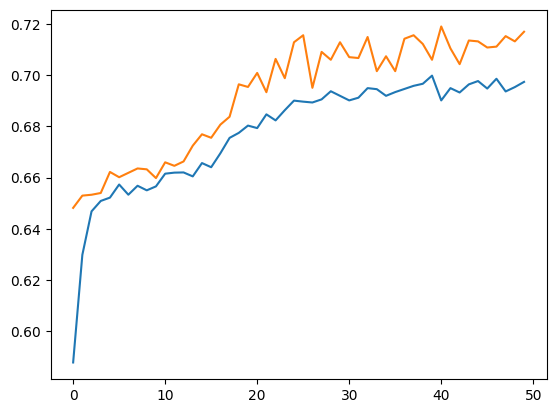

In [18]:
# Import necessary libraries
import os
import json
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pytz
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



def parse_tweet_file(file_path, start_date, end_date):
    tweets = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                tweet_data = json.loads(line)
                tweet_text = " ".join(tweet_data['text']) if isinstance(tweet_data['text'], list) else tweet_data['text']
                tweet_time = parser.parse(tweet_data['created_at'])
                tweet_time = tweet_time.astimezone(pytz.timezone('US/Eastern'))
                date_key = tweet_time.date()
                if start_date <= date_key <= end_date:
                    tweets.append((tweet_text, date_key))
            except json.JSONDecodeError:
                continue
    return tweets

def parse_price_file(file_path, start_date, end_date):
    prices = {}
    volumes = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < 6:
                continue
            date_str = fields[0]
            try:
                price_time = datetime.datetime.strptime(date_str, '%Y-%m-%d')
                date_key = price_time.date()
                if start_date <= date_key <= end_date:
                    close_price_str = fields[4]
                    volume_str = fields[5]
                    close_price = float(close_price_str)
                    volume = float(volume_str)
                    prices[date_key] = close_price
                    volumes[date_key] = volume
            except ValueError:
                continue
    return prices, volumes


#function to load sentiments and process the information so RNN can get different features out of it
def load_data_with_sentiment(tweet_root_dir, price_root_dir, start_date, end_date, tickers):
    sentiments = []
    labels = []
    sentiment_changes = []
    price_changes = []
    moving_averages = []
    volumes = []
    days_of_week = []
    month_average = []
    sia = SentimentIntensityAnalyzer()

    for ticker in tickers:
        tweet_dir = os.path.join(tweet_root_dir, ticker)
        price_file = os.path.join(price_root_dir, f"{ticker}.txt")

        if not os.path.isdir(tweet_dir) or not os.path.isfile(price_file):
            continue

        ticker_prices, ticker_volumes = parse_price_file(price_file, start_date, end_date)
        if not ticker_prices:
            continue

        tweets_by_date = {}
        for file in os.listdir(tweet_dir):
            file_path = os.path.join(tweet_dir, file)
            if os.path.isfile(file_path):
                tweets_with_dates = parse_tweet_file(file_path, start_date, end_date)
                for tweet_text, date_key in tweets_with_dates:
                    if date_key not in tweets_by_date:
                        tweets_by_date[date_key] = []
                    tweets_by_date[date_key].append(tweet_text)
        if not tweets_by_date:
            continue

        daily_sentiments = {}
        for date, tweets in tweets_by_date.items():
            daily_compound_scores = [sia.polarity_scores(tweet)['compound'] for tweet in tweets]
            if daily_compound_scores:
                daily_sentiments[date] = np.mean(daily_compound_scores)

        sorted_dates = sorted(ticker_prices.keys())
        prev_sentiment = None
        prev_price = None
        moving_avg_window = 5
        for i, date_today in enumerate(sorted_dates[:-1]):
            date_tomorrow = sorted_dates[i + 1]
            if date_today in daily_sentiments and date_today in ticker_prices:
                # Use features up to date_today to predict price movement on date_tomorrow
                sentiment_score = daily_sentiments[date_today]
                price_today = ticker_prices[date_today]
                volume_today = ticker_volumes[date_today]
                
                # Label is based on price change from date_today to date_tomorrow
                price_tomorrow = ticker_prices[date_tomorrow]
                label = 1 if price_tomorrow > price_today else 0
                
                # Features should not use data from date_tomorrow or later
                if i >= moving_avg_window:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i - moving_avg_window, i)])
                else:
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(i)])

                next_day = date_today + datetime.timedelta(days=1)
                if next_day in ticker_prices:
                    price_next = ticker_prices[next_day]
                    price_diff = price_next - price_today
                    label = 1 if price_diff > 0 else 0
                    sentiment_change = sentiment_score - prev_sentiment if prev_sentiment is not None else 0
                    price_change = price_today - prev_price if prev_price is not None else 0
                    moving_avg = np.mean([ticker_prices[sorted_dates[j]] for j in range(max(0, i - moving_avg_window + 1), i + 1)])
                    day_of_week = date_today.weekday()

                    sentiments.append(sentiment_score)
                    sentiment_changes.append(sentiment_change)
                    price_changes.append(price_change)
                    moving_averages.append(moving_avg)
                    volumes.append(volume_today)
                    days_of_week.append(day_of_week)
                    labels.append(label)

                    prev_sentiment = sentiment_score
                    prev_price = price_today

    return sentiments, sentiment_changes, price_changes, moving_averages, volumes, days_of_week, labels



tweet_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/tweet/preprocessed/'
price_root_dir = '/home/sigurds/ikt450/Project/Data/stocknet-dataset-master/price/preprocessed/'

# Define new date ranges
"""
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2015, 6, 30)
test_start_date = datetime.date(2015, 7, 1)
test_end_date = datetime.date(2016, 1, 1)

"""
train_start_date = datetime.date(2014, 1, 1)
train_end_date = datetime.date(2016, 1, 1)
test_start_date = datetime.date(2014, 1, 1)
test_end_date = datetime.date(2016, 1, 1)



# Get all available tickers from the tweet data directory
all_tickers = [ticker for ticker in os.listdir(tweet_root_dir) if os.path.isdir(os.path.join(tweet_root_dir, ticker))]

# Split the tickers into training and testing sets with no overlap
train_tickers, test_tickers = train_test_split(all_tickers, test_size=0.2, random_state=42)

# Verify that there is no overlap between train_tickers and test_tickers
assert set(train_tickers).isdisjoint(set(test_tickers)), "Training and testing tickers overlap!"

# Load training data from train tickers
(sentiments_train, sentiment_changes_train, price_changes_train,
 moving_averages_train, volumes_train, days_of_week_train, labels_train) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, train_start_date, train_end_date, train_tickers)

# Load testing data from test tickers
(sentiments_test, sentiment_changes_test, price_changes_test,
 moving_averages_test, volumes_test, days_of_week_test, labels_test) = load_data_with_sentiment(
    tweet_root_dir, price_root_dir, test_start_date, test_end_date, test_tickers)

if not sentiments_train or not sentiments_test:
    print("No data was loaded. Please check your data files and parsing functions.")
else:
    # Convert lists to NumPy arrays
    sentiments_train = np.array(sentiments_train)
    sentiment_changes_train = np.array(sentiment_changes_train)
    price_changes_train = np.array(price_changes_train)
    moving_averages_train = np.array(moving_averages_train)
    volumes_train = np.array(volumes_train)
    days_of_week_train = np.array(days_of_week_train)
    labels_train = np.array(labels_train)

    sentiments_test = np.array(sentiments_test)
    sentiment_changes_test = np.array(sentiment_changes_test)
    price_changes_test = np.array(price_changes_test)
    moving_averages_test = np.array(moving_averages_test)
    volumes_test = np.array(volumes_test)
    days_of_week_test = np.array(days_of_week_test)
    labels_test = np.array(labels_test)

    # Stack features
    x_train = np.column_stack((sentiments_train, sentiment_changes_train, price_changes_train,
                               moving_averages_train, volumes_train, days_of_week_train))
    x_test = np.column_stack((sentiments_test, sentiment_changes_test, price_changes_test,
                              moving_averages_test, volumes_test, days_of_week_test))

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    # Reshape data
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))


    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, labels_train))
    train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, labels_test))
    test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

       # Build and compile the model with Simple RNN
    model = models.Sequential([
        layers.Input(shape=(1, 6)),  # Input shape adjusted to (time_steps, features)
        layers.SimpleRNN(64, return_sequences=False),  # SimpleRNN with 64 units
        layers.Dropout(0.3),  # Dropout to prevent overfitting
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Dense layer with ReLU activation
        layers.BatchNormalization(),  # Batch normalization for stable training
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])



# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

# Evaluate model on test data
y_pred_prob = model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
precision = precision_score(labels_test, y_pred)
recall = recall_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plotting test accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')






In [ ]:

plt.savefig('SimpleRNN_ACC_FULLDATE.pdf', format='pdf')
plt.close()
